In [1]:
!git clone https://github.com/rslim087a/track
#the above repository consists of various images captures during the training 
#period of the self driving car by making use of 3 cameras present on the windsheild of the car(on left, right and center)
#the data captured is the 3 images, steer angle, thrust and brake information for the car

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 5.51 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [2]:
!ls track
#this command is used to list the components present in the above repository


driving_log.csv  IMG


In [3]:
!pip3 install imgaug
#this library is used for data augmentation, since our self driving model didnt work in the best possible manner we would increase the dataset with data augmentation

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D,Dropout,Dense,Flatten
from sklearn.utils import shuffle
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath
#ntpath is a library that would be used to limit the path of our images to only the leaf

In [6]:
data_dir='track'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(data_dir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [7]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail

data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


<BarContainer object of 25 artists>

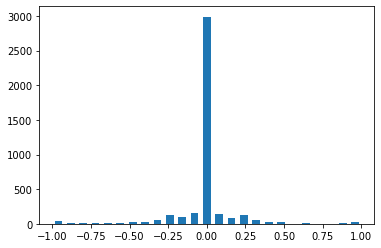

In [10]:
#lets visualize the distribution of steering angles
#here, we are have chosen number of bins to be equal to 25 since we want our steering data to be centeres around 0
#0 implies driving straight
num_bins=25
hist,bins=np.histogram(data['steering'],num_bins)
print(bins)
#since data here is not centered around 0, we perform the element wise additon with the shifted array and divide by 2 since each value would double up on addition
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
#now it is evident that the most commmon steering angle is 0 radians


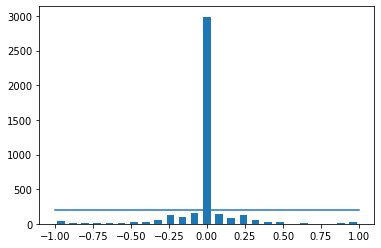

In [11]:
#we can observe that 0 degree occurs alot more than other angles hence this may cause bias during testing
#therefore we would set some maximum threshold for samples
samples_per_bin=200
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total_data: 4053
removed: 2790
remaining: 1263


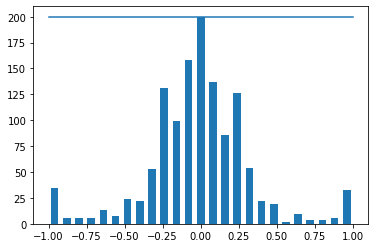

In [12]:
# lets cut off the excess data
print('total_data:', len(data))
remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining:', len(data))

hist,_=np.histogram(data['steering'],num_bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))





In [13]:
print(data.iloc[0])
def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    #this would select a particular row of our dataset
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
    #indexed_data[3] contains steering angles
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings

image_paths,steerings=load_img_steering(data_dir + '/IMG',data)
#now we have our dataset for images captured from the center camera and their corresponding steering angle

center      center_2018_07_16_17_11_44_137.jpg
left          left_2018_07_16_17_11_44_137.jpg
right        right_2018_07_16_17_11_44_137.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                                  0.59835
Name: 8, dtype: object


In [14]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=6)
print('Training Samples= {} \nValidation Samples={}'.format(len(X_train),len(X_valid)))

Training Samples= 1010 
Validation Samples=253


Text(0.5, 1.0, 'Validation set')

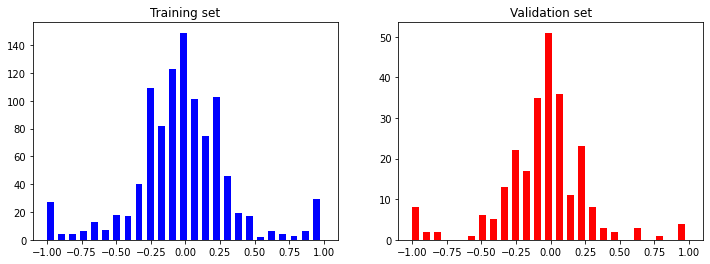

In [15]:
fig,axes=plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid,bins=num_bins,width=0.05,color='red')
axes[1].set_title('Validation set')

In [16]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  #Affine library consists of functions that maintain the lines and planes of the images
  image=zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

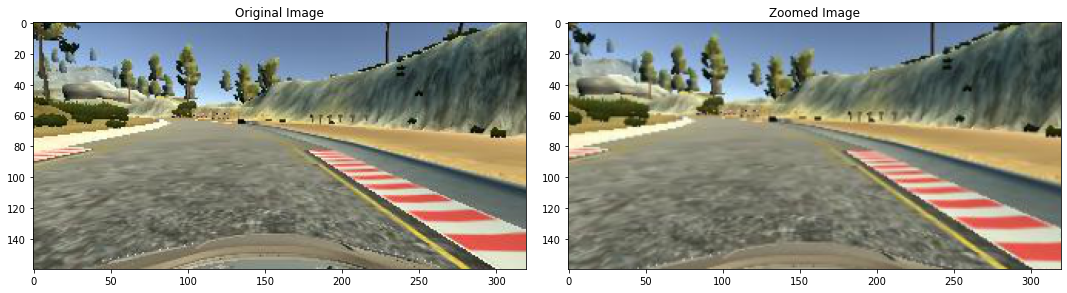

In [21]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [24]:
def pan(image):
  pan=iaa.Affine(translate_percent={"x":(-0.1,0.1),"y":(-0.1,0.1)})
  image=pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

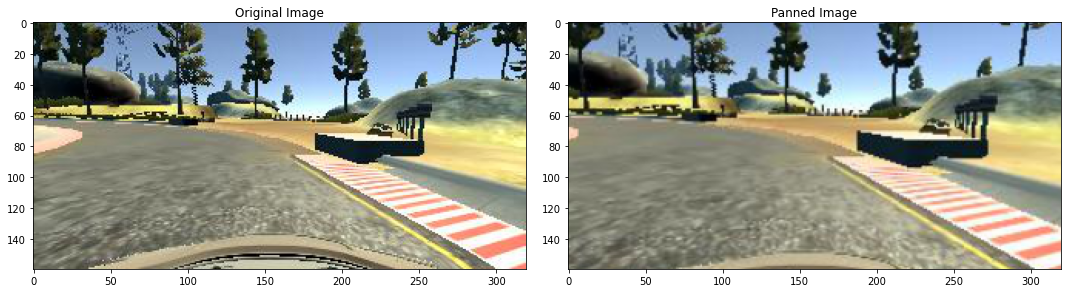

In [26]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
panned_image=zoom(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [27]:
def img_random_brightness(image):
  brightness=iaa.Multiply((0.2,1.2))
  #here we have set the image multiplying factor to be between 0.2 to 1.2 since our model reacts more to dark images, hence it would be more probable that the number selected would be less than 0
  image=brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

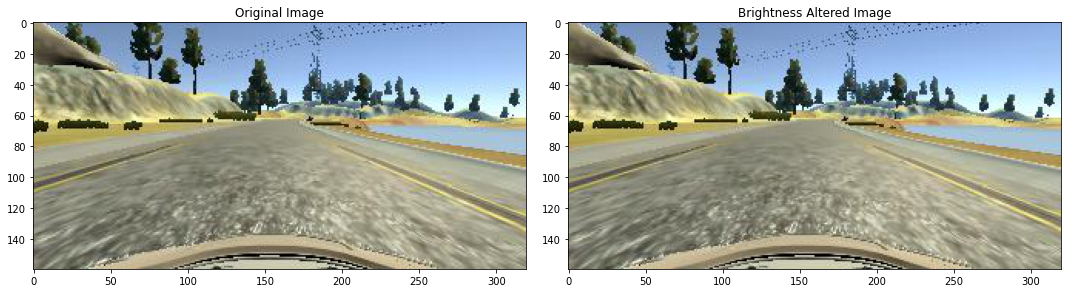

In [31]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
brightness_altered_image=img_random_brightness(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [32]:
def img_random_flip(image,steering_angle):
  image=cv2.flip(image,1)
  #1 for horizontal flip , 0 for vertical and -1 for both
  steering_angle=-steering_angle
  return image,steering_angle

In [ ]:
random_index=random.randint(0,1000)
image=image_paths[random_index]
steering_angle=steerings[random_index]

original_image=mpimg.imread(image)
brightness_altered_image=img_random_brightness(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [23]:
#we can observe a uniform distribution among training and test sets

def img_preprocess(img):
  img=mpimg.imread(img)
  #we crop the image from the the top since that is an additional scenic view, and the bottom since it shows the hood of the car, which has no relation with the prediction of steering angle
  img=img[60:135,:,:]
  #Y=luminousity and UV=chromiance of the image
  img =cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  #to smoothen our image we use gaussian blur here
  img=cv2.GaussianBlur(img,(3,3),0)
  #to make computation easier we resize our images, the size chosen is suitable for nvidia
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

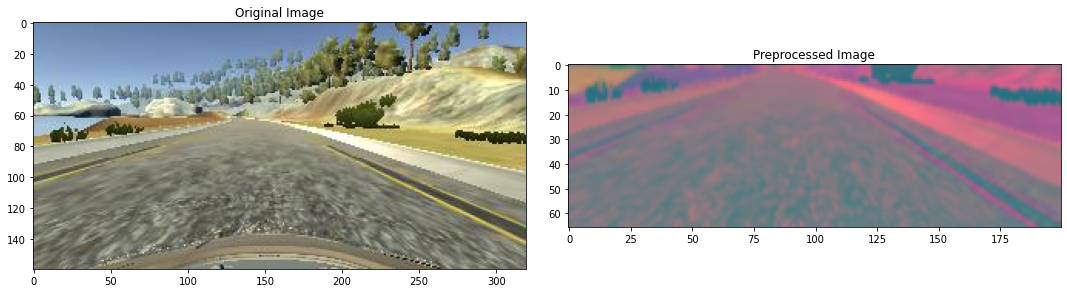

In [ ]:
#now let us pick and plot a random image from our dataset
image=image_paths[100]

original_image=mpimg.imread(image)
preprocessed_image=img_preprocess(image)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
X_train=np.array(list(map(img_preprocess,X_train)))
X_valid=np.array(list(map(img_preprocess,X_valid)))

(1010, 66, 200, 3)


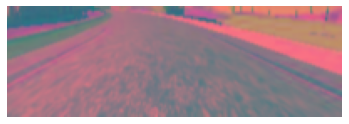

In [ ]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)
#using the above 2 cells we have performed preprocessing over the entire training and validation set of our images

In [ ]:
def nvidia_model():
 
  model = Sequential()
  
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  # 24 here equals to the number of filters required for the first layer of nvidia model, check nvidia layers layout
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  # we set the kernel size as 5*5 and the stride represents that we will consider 2*2 pixels together unlike done earlier
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  #all the above layers follow the pattern of nvidia layer model, dropout layer is added to randomly set 50% of the input as zero s as to reduce the chances of overfitting

  model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  #lr has been set out to be low so that our model turns out to be good
  optimizer= Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

  # after compiling the model(havin relu activation function) we observe that our validation loss and training loss come out to be pretty same, which may imply the scenario of dead relu
  #dead relu is a condition in which 1 or more nodes of our model die, this may happen when a negative dataset is fed into the node
  #since relu then returns 0 and this causes the weight to never change, therefore we use 'elu' function instead, which is almost like relu but return negative gradient for negative inputs
  #hence avoiding the dead relu case 

In [ ]:
model=nvidia_model()
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

In [ ]:
history=model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),batch_size=100,verbose=1,shuffle=1)

Train on 1010 samples, validate on 253 samples
Epoch 1/30
1010/1010 [==============================] - 7s 7ms/step - loss: 1.4423 - val_loss: 0.1395
Epoch 2/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.3555 - val_loss: 0.1041
Epoch 3/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.2034 - val_loss: 0.1016
Epoch 4/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1789 - val_loss: 0.1038
Epoch 5/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1597 - val_loss: 0.0929
Epoch 6/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1382 - val_loss: 0.0932
Epoch 7/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1367 - val_loss: 0.0861
Epoch 8/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1152 - val_loss: 0.0796
Epoch 9/30
1010/1010 [==============================] - 7s 7ms/step - loss: 0.1163 - val_loss: 0.0759
Epoch 10/30
1010/1010 [============

Text(0.5, 0, 'Epoch')

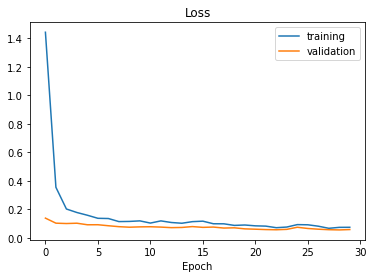

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')
#we can observe that our model fits perfectly without any overfitting

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>